# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

from nltk.stem.porter import PorterStemmer

from  sklearn.calibration import CalibratedClassifierCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from prettytable import PrettyTable
from sklearn.linear_model import SGDClassifier
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect(r'C:\Sandy\privy\AI\Data Sets\Amazon Food rev dataset\database.sqlite') 


In [3]:
#preprocessed_data=pd.read_sql_query(""" SELECT * FROM Reviews  ORDER BY time LIMIT 300""", con) 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

#Took 3000 points from each Category i.e from Positive reviews and Negative Reviews
#Negative Data
Neg_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score < 3 ORDER BY time LIMIT 20000""", con) 
#Positive Data
Pos_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score >= 3  ORDER BY time LIMIT 20000""", con) 

Neg_data.head()
preprocessed_data =pd.concat([Neg_data,Pos_data])
print("Total Sample Points : ",preprocessed_data.shape)
#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print("\n Sample Points : ")
preprocessed_data.head()

Total Sample Points :  (40000, 10)

 Sample Points : 


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,230269,B00004RYGX,A1B2IZU1JLZA6,Wes,19,23,1,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
1,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,1,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
2,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,1,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
3,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,2,992217600,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...
4,230265,B00004RYGX,AZRJH4JFB59VC,Lynwood E. Hines,21,23,1,997228800,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...


In [4]:
preprocessed_data=preprocessed_data[preprocessed_data['HelpfulnessNumerator']<=preprocessed_data['HelpfulnessDenominator']]

In [5]:
preprocessed_data.shape

(40000, 10)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
#Sorting data according to ProductId in ascending order
preprocessed_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
80,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,5,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
569,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,4,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
43,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,5,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
68,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,5,1018396800,A great way to learn the months,This is a book of poetry about the months of t...
14368,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,5,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...
...,...,...,...,...,...,...,...,...,...,...
12530,360574,B009M2LRTA,A1DY3EW6Q0B5K5,Cara Hansson,0,2,2,1259625600,ew... very alcoholy,to me the orange one tastes like vodka!!! I ca...
4765,501584,B009M2LUEW,A1PY4BCMI543EX,E. Barrios,4,17,1,1214611200,Yuck!,I'm a big fan of Zevia sodas and drink several...
10071,32541,B009NTCO4O,A3DO26SPN14CG1,M. Grinnell,9,9,5,1169164800,Great gift!,I gave this to my Brother-in-law's family for ...
11741,264593,B009QEBGIQ,A3R6YKLCA0L5N0,minette,15,17,5,1172188800,Exceptional Rice!,I've tasted different rice varieties and this ...


In [7]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = preprocessed_data['Score']
positiveNegative = actualScore.map(partition) 
preprocessed_data['Score'] = positiveNegative
print("Number of data points in our dataset", preprocessed_data.shape)
preprocessed_data.head(3)

Number of data points in our dataset (40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,230269,B00004RYGX,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
1,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
2,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."


In [8]:
#Deduplication of entries
final_data=preprocessed_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

print(final_data.shape)



(28281, 10)


In [9]:
#Checking to see how much % of data still remains

(final_data['Id'].size*1.0)/(preprocessed_data['Id'].size*1.0)*100

70.7025

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [12]:
final=final.sort_values('Time',axis=0, ascending=True , inplace=False, kind='quicksort', na_position='last')

final['Score'].value_counts()

1    14329
0    13952
Name: Score, dtype: int64

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?

y=final[['Score']]
print(len(y))

(28281, 10)
28281


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews_text = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_text.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 28281/28281 [00:17<00:00, 1635.00it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [17]:

from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 28281/28281 [00:14<00:00, 1925.50it/s]


<h2 style="background-color:#fffff">Concatenating Summary and text reviews</h2>

In [18]:
preprocessed_reviews=[]
for i in tqdm(range(len(preprocessed_reviews_text))):
    preprocessed_reviews.append(preprocessed_reviews_text[i]+' '+preprocessed_reviews_summary[i])


100%|████████████████████████████████████████████████████████████████████████| 28281/28281 [00:00<00:00, 642838.39it/s]


In [19]:
preprocessed_reviews[0]

'witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college every book educational'

In [20]:
X_1, X_test, y_t, y_test = train_test_split(preprocessed_reviews, y, test_size=0.5,shuffle=False,stratify=None)
X_train, CV, y_train, y_CV = train_test_split(X_1, y_t, test_size=0.3,shuffle=False,stratify =None)

Dataset=['X_train','CV','X_test']
print(Dataset)

['X_train', 'CV', 'X_test']


In [21]:
#print(y_test.value_counts)

print(y_test.Score.value_counts())

0    12483
1     1658
Name: Score, dtype: int64


In [22]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# [4] Featurization

## [4.1] BAG OF WORDS

In [23]:

#BoW for Train data
BOW_vec = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
BOW_vec.fit(X_train)
print("some feature names ", BOW_vec.get_feature_names()[:10])
print('='*50)

X_train_BOW = BOW_vec.transform(X_train)
print("the type of count vectorizer of Train data ",type(X_train_BOW))
print("the shape of out text BOW vectorizer of Train data",X_train_BOW.get_shape())
print("the number of unique words", X_train_BOW.get_shape()[1])
print('='*100)

X_CV_BOW=BOW_vec.transform(CV)
print("the type of count vectorizer of CV data",type(X_CV_BOW))
print("the shape of out text BOW vectorizer  of CV data",X_CV_BOW.get_shape())
print("the number of unique words ", X_CV_BOW.get_shape()[1])

print('='*100)
#BoW for Test Data

X_test_BOW = BOW_vec.transform(X_test)

print("the type of count vectorizer of Test Data",type(X_test_BOW))
print("the shape of out text BOW vectorizer of Test data",X_test_BOW.get_shape())
print("the number of unique words ", X_test_BOW.get_shape()[1])


some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'along', 'also', 'alternative']
the type of count vectorizer of Train data  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer of Train data (9898, 500)
the number of unique words 500
the type of count vectorizer of CV data <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  of CV data (4242, 500)
the number of unique words  500
the type of count vectorizer of Test Data <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer of Test data (14141, 500)
the number of unique words  500


## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [24]:

max1=0
AUC_Train_l1=[]
AUC_Train_l2=[]
AUC_CV_l1=[]
AUC_CV_l2=[]
alpha = [10**x for x in range(-4,5)]
#print(alpha)
#alpha = [10**-4]
penalty_lst=['l1','l2']
#penalty_lin_opt=None
for pnlty in penalty_lst:
    for c in alpha: 
        #print(pnlty)
        model_BOW=SGDClassifier(loss='hinge',learning_rate='constant',class_weight ='balanced',alpha=c,penalty=pnlty,eta0=0.1,max_iter=1000)
        model_BOW=model_BOW.fit(X_train_BOW,y_train)         
        #y_CV_pred_proba = model_BOW.predict_proba(CV_BOW)[:,1]      
        cal_clf_BOW_cv=CalibratedClassifierCV(model_BOW,cv='prefit')
        cal_clf_BOW_cv.fit(X_train_BOW,y_train)
        y_CV_pred_proba=cal_clf_BOW_cv.predict_proba(X_CV_BOW) [:,1] 
        y_Train_pred_proba = cal_clf_BOW_cv.predict_proba(X_train_BOW)[:,1] 
        #print(y_CV_pred_proba)
        #print(y_CV)
        if pnlty == 'l1':
            AUC_CV_l1.append(roc_auc_score(y_CV,y_CV_pred_proba))
            AUC_Train_l1.append(roc_auc_score(y_train,y_Train_pred_proba))
        else:
            AUC_CV_l2.append(roc_auc_score(y_CV,y_CV_pred_proba))
            AUC_Train_l2.append(roc_auc_score(y_train,y_Train_pred_proba))
        temp=roc_auc_score(y_CV,y_CV_pred_proba)
        
        if max1 < temp:
            max1=temp        
            c_opt=c
            penalty_lin_BOW=pnlty
       

AUC is max when alpha is 0.0001, penalty is l2 with AUC = 0.8542559248844823


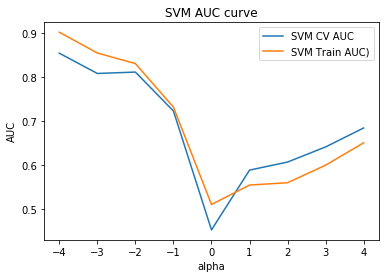

In [25]:
#Generate plot
#print(penalty_lin_BOW)
print("AUC is max when alpha is {}, penalty is {} with AUC = {}".format(c_opt,penalty_lin_BOW,max1))
c_BOW_lin=c_opt
AUC_CV=[]
AUC_train=[]
if penalty_lin_BOW == 'l1':
    AUC_CV=AUC_CV_l1   
    AUC_Train=AUC_Train_l1
else:
    AUC_CV=AUC_CV_l2
    AUC_Train=AUC_Train_l2
plt.plot(np.log10(alpha),AUC_CV, label='SVM CV AUC')
plt.plot(np.log10(alpha),AUC_Train,label='SVM Train AUC)')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.legend()
plt.title('SVM AUC curve')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.16      0.27     12483
           1       0.13      0.98      0.24      1658

    accuracy                           0.25     14141
   macro avg       0.56      0.57      0.25     14141
weighted avg       0.89      0.25      0.27     14141

Test data AUC of SVM with BOW Implentation  :  0.8525050280685713
Train data AUC of SVM with BOW Implentation  :  0.911362778406946


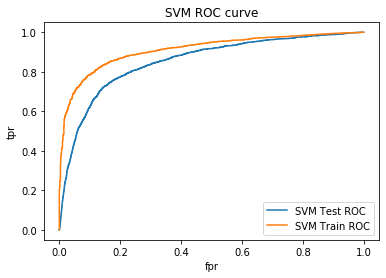

the maximum value of tpr*(1-fpr) 0.7149719419242369 for threshold 0.894
Train confusion matrix
[[ 930  138]
 [1580 7250]]


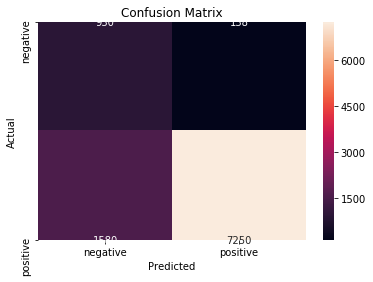

the maximum value of tpr*(1-fpr) 0.6236737693057491 for threshold 0.911
Test confusion matrix
[[10204  2279]
 [  393  1265]]


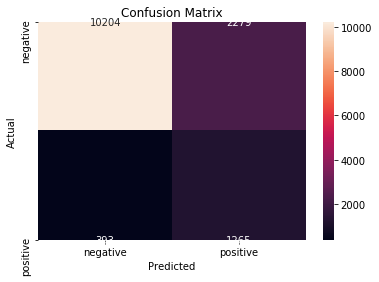

Accuracy of SVM when alpha=0.0001, with penalty = l2 is 0.25323527331871865


In [26]:

SGD_BOW =SGDClassifier(loss='hinge',learning_rate='constant',class_weight='balanced',alpha=c_BOW_lin,penalty=penalty_lin_BOW,eta0=0.1,max_iter=1000)
SGD_BOW_lin=SGD_BOW.fit(X_train_BOW,y_train)

cal_clf_BOW_lin=CalibratedClassifierCV(SGD_BOW_lin,cv='prefit')
cal_clf_BOW_lin.fit(X_CV_BOW,y_CV)

y_pred=cal_clf_BOW_lin.predict(X_test_BOW)
print(classification_report(y_test,y_pred))

#predict probabilities
y_Test_pred_proba = cal_clf_BOW_lin.predict_proba(X_test_BOW)[:,1]
y_Train_pred_proba = cal_clf_BOW_lin.predict_proba(X_train_BOW)[:,1]

#code for AUC
fpr_Test, tpr_Test, thresholds_Test = roc_curve(y_test, y_Test_pred_proba)
fpr_Train, tpr_Train, thresholds_train = roc_curve(y_train, y_Train_pred_proba)
print("Test data AUC of SVM with BOW Implentation  : ",roc_auc_score(y_test,y_Test_pred_proba))
AUC_BOW_lin=roc_auc_score(y_test,y_Test_pred_proba)
print("Train data AUC of SVM with BOW Implentation  : ",roc_auc_score(y_train,y_Train_pred_proba))


#generate plot
plt.plot(fpr_Test,tpr_Test, label='SVM Test ROC')
plt.plot(fpr_Train,tpr_Train, label='SVM Train ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('SVM ROC curve')
plt.show()


#confusion matrix of train data
best_t = find_best_threshold(thresholds_train, fpr_Train, tpr_Train)
print("Train confusion matrix")
conf_matrix=confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t))
print(confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t)))

class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#confusion matrix of test data
best_t = find_best_threshold(thresholds_Test, fpr_Test, tpr_Test)
print("Test confusion matrix")
conf_matrix=confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t))
print(confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t)))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy_BOW_lin=cal_clf_BOW_lin.score(X_test_BOW, y_test)
print('Accuracy of SVM when alpha={}, with penalty = {} is {}'.format(c_BOW_lin,penalty_lin_BOW,Accuracy_BOW_lin))

<h4>Top 10 Negative features for Linear SVM</h4>

In [27]:
Weight_index=SGD_BOW_lin.coef_[0].argsort()
#print(SGD_BOW_lin.coef_[0])
#print(Weight_index)
#print(SGD_BOW_lin.coef_[0][Weight_index])
print(np.take(BOW_vec.get_feature_names(),Weight_index[0:10]))

['thought' 'instead' 'life' 'money' 'dry' 'pieces' 'not' 'artificial'
 'leaves' 'version']


<h4>Top 10 positive features for Linear SVM</h4>

In [28]:
Weight_index=SGD_BOW_lin.coef_[0].argsort()
weight_index_len=len(SGD_BOW_lin.coef_[0])
print(np.take(BOW_vec.get_feature_names(),Weight_index[weight_index_len-10:]))

['highly' 'salad' 'cold' 'clean' 'amazing' 'delicious' 'best' 'variety'
 'yummy' 'loves']


###  Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [29]:

max1=0
AUC_Train=[]
AUC_CV=[]
#alpha = [10**x for x in range(-4,5)]
#alpha = [10**-4]
for c in tqdm(alpha):        
    model=SVC(C=c, kernel='rbf', probability=True, cache_size=200, class_weight='balanced', decision_function_shape='ovo')
    model_BOW=model.fit(X_train_BOW,y_train)         
    y_CV_pred_proba = model_BOW.predict_proba(X_CV_BOW)[:,1]      
    #cal_clf_BOW_cv=CalibratedClassifierCV(model_BOW,cv='prefit')
    #cal_clf_BOW_cv.fit(X_train_BOW,y_train)
    y_CV_pred_proba=model_BOW.predict_proba(X_CV_BOW) [:,1] 
    y_Train_pred_proba = model_BOW.predict_proba(X_train_BOW)[:,1] 
    #print(y_CV_pred_proba)
    #print(y_CV)
    temp=roc_auc_score(y_CV,y_CV_pred_proba)
    AUC_CV.append(roc_auc_score(y_CV,y_CV_pred_proba))
    if max1 < temp:
        max1=temp        
        c_opt=c
    AUC_Train.append(roc_auc_score(y_train,y_Train_pred_proba))

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [18:16<00:00, 121.88s/it]


AUC is max when alpha is 1 with AUC = 0.8936095065642324


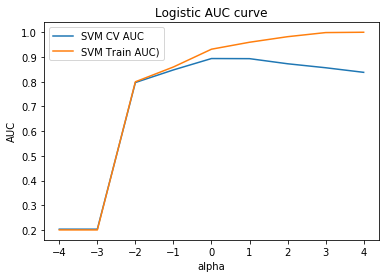

In [30]:
#Generate plot
print("AUC is max when alpha is {} with AUC = {}".format(c_opt,max1))
c_BOW_rbf=c_opt
plt.plot(np.log10(alpha),AUC_CV, label='SVM CV AUC')
plt.plot(np.log10(alpha),AUC_Train,label='SVM Train AUC)')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.legend()
plt.title('Logistic AUC curve')
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.82      0.89     12483
           1       0.37      0.78      0.50      1658

    accuracy                           0.82     14141
   macro avg       0.67      0.80      0.70     14141
weighted avg       0.90      0.82      0.84     14141

Test data AUC of SVM with BOW Implentation  :  0.8785359910950544
Train data AUC of SVM with BOW Implentation  :  0.9314028295604447


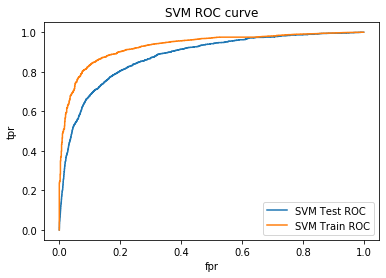

the maximum value of tpr*(1-fpr) 0.7535173332315354 for threshold 0.867
Train confusion matrix
[[ 950  118]
 [1350 7480]]


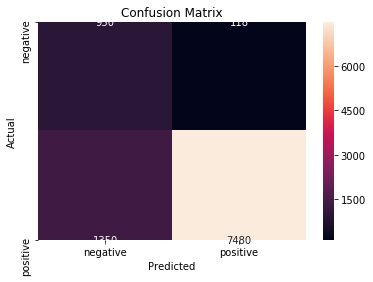

the maximum value of tpr*(1-fpr) 0.6456901047668496 for threshold 0.889
Test confusion matrix
[[10264  2219]
 [  356  1302]]


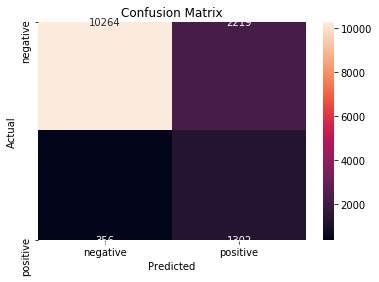

Accuracy of SVM when alpha=1 is 0.8198147231454636


In [31]:

SVC_BOW =SVC(C=c_BOW_rbf, kernel='rbf', probability=True, cache_size=200, class_weight='balanced', decision_function_shape='ovo')
SVC_BOW_rbf=SVC_BOW.fit(X_train_BOW,y_train)

#cal_clf_BOW_lin=CalibratedClassifierCV(SVC_BOW_rbf,cv='prefit')
#cal_clf_BOW_lin.fit(X_CV_BOW,y_CV)

y_pred=SVC_BOW_rbf.predict(X_test_BOW)
print(classification_report(y_test,y_pred))

#predict probabilities
y_Test_pred_proba = SVC_BOW_rbf.predict_proba(X_test_BOW)[:,1]
y_Train_pred_proba = SVC_BOW_rbf.predict_proba(X_train_BOW)[:,1]

#code for AUC
fpr_Test, tpr_Test, thresholds_Test = roc_curve(y_test, y_Test_pred_proba)
fpr_Train, tpr_Train, thresholds_train = roc_curve(y_train, y_Train_pred_proba)
print("Test data AUC of SVM with BOW Implentation  : ",roc_auc_score(y_test,y_Test_pred_proba))
AUC_BOW_rbf=roc_auc_score(y_test,y_Test_pred_proba)
print("Train data AUC of SVM with BOW Implentation  : ",roc_auc_score(y_train,y_Train_pred_proba))


#generate plot
plt.plot(fpr_Test,tpr_Test, label='SVM Test ROC')
plt.plot(fpr_Train,tpr_Train, label='SVM Train ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('SVM ROC curve')
plt.show()


#confusion matrix of train data
best_t = find_best_threshold(thresholds_train, fpr_Train, tpr_Train)
print("Train confusion matrix")
conf_matrix=confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t))
print(confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t)))

class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#confusion matrix of test data
best_t = find_best_threshold(thresholds_Test, fpr_Test, tpr_Test)
print("Test confusion matrix")
conf_matrix=confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t))
print(confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t)))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy_BOW_rbf=SVC_BOW_rbf.score(X_test_BOW, y_test)
print('Accuracy of SVM when alpha={} is {}'.format(c_BOW_rbf,Accuracy_BOW_rbf))

###  Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [32]:

tf_idf_vect= TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tf_idf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_tf_idf))
print("the shape of out text TFIDF vectorizer ",X_train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tf_idf.get_shape()[1])
print('='*100)
CV_tf_idf = tf_idf_vect.transform(CV)
print("the type of count vectorizer ",type(CV_tf_idf))
print("the shape of out text TFIDF vectorizer ",CV_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", CV_tf_idf.get_shape()[1])
print('='*100)

X_test_tf_idf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_tf_idf))
print("the shape of out text TFIDF vectorizer ",X_test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_test_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'along', 'also', 'alternative']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9898, 500)
the number of unique words including both unigrams and bigrams  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4242, 500)
the number of unique words including both unigrams and bigrams  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (14141, 500)
the number of unique words including both unigrams and bigrams  500


In [33]:
from sklearn.preprocessing import StandardScaler


SS=StandardScaler(with_mean=False).fit(X_train_tf_idf)
X_train_tf_idf=SS.transform(X_train_tf_idf)
X_CV_tf_idf= SS.transform(CV_tf_idf)
X_test_tf_idf=StandardScaler(with_mean=False).fit_transform(X_test_tf_idf)

In [34]:

max1=0
AUC_Train_l1=[]
AUC_Train_l2=[]
AUC_CV_l1=[]
AUC_CV_l2=[]
#alpha = [10**x for x in range(-4,5)]
#print(alpha)
#alpha = [10**-4]
penalty_lst=['l1','l2']
#penalty_lin_opt=None
for pnlty in penalty_lst:
    for c in alpha: 
        #print(pnlty)
        model=SGDClassifier(loss='hinge',learning_rate='constant',class_weight='balanced',alpha=c,penalty=pnlty,eta0=0.1,max_iter=1000)
        model_tf_idf=model.fit(X_train_tf_idf,y_train)         
            
        cal_clf_tf_idf_cv=CalibratedClassifierCV(model_tf_idf,cv='prefit')
        cal_clf_tf_idf_cv.fit(X_train_tf_idf,y_train)
        y_CV_pred_proba=cal_clf_tf_idf_cv.predict_proba(X_CV_tf_idf) [:,1] 
        y_Train_pred_proba = cal_clf_tf_idf_cv.predict_proba(X_train_tf_idf)[:,1] 
        #print(y_CV_pred_proba)
        #print(y_CV)
        if pnlty == 'l1':
            AUC_CV_l1.append(roc_auc_score(y_CV,y_CV_pred_proba))
            AUC_Train_l1.append(roc_auc_score(y_train,y_Train_pred_proba))
        else:
            AUC_CV_l2.append(roc_auc_score(y_CV,y_CV_pred_proba))
            AUC_Train_l2.append(roc_auc_score(y_train,y_Train_pred_proba))
        temp=roc_auc_score(y_CV,y_CV_pred_proba)
        
        if max1 < temp:
            max1=temp        
            c_opt=c
            penalty_lin_tf_idf=pnlty
       

l2
AUC is max when alpha is 0.0001, penalty is l2 with AUC = 0.8632382854371491


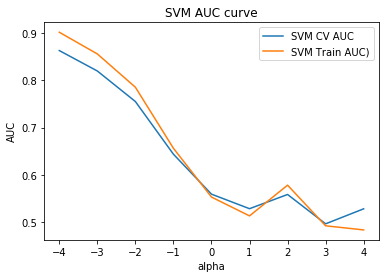

In [35]:
#Generate plot
print(penalty_lin_tf_idf)
print("AUC is max when alpha is {}, penalty is {} with AUC = {}".format(c_opt,penalty_lin_tf_idf,max1))
c_tf_idf_lin=c_opt
AUC_CV=[]
AUC_Train=[]
if penalty_lin_tf_idf == 'l1':
    AUC_CV=AUC_CV_l1   
    AUC_Train=AUC_Train_l1
else:
    AUC_CV=AUC_CV_l2
    AUC_Train=AUC_Train_l2
plt.plot(np.log10(alpha),AUC_CV, label='SVM CV AUC')
plt.plot(np.log10(alpha),AUC_Train,label='SVM Train AUC)')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.legend()
plt.title('SVM AUC curve')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.05      0.10     12483
           1       0.12      1.00      0.22      1658

    accuracy                           0.16     14141
   macro avg       0.56      0.52      0.16     14141
weighted avg       0.89      0.16      0.11     14141

Test data AUC of SVM with tf_idf Implentation  :  0.8491470233051329
Train data AUC of SVM with tf_idf Implentation  :  0.9004175839091284


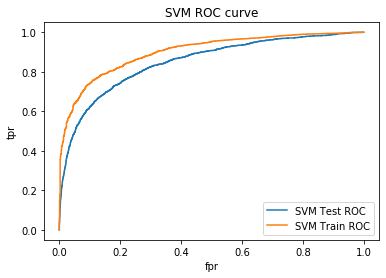

the maximum value of tpr*(1-fpr) 0.6772424192296436 for threshold 0.905
Train confusion matrix
[[ 922  146]
 [1903 6927]]


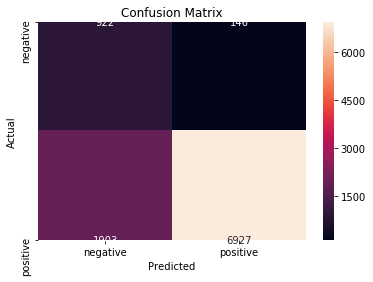

the maximum value of tpr*(1-fpr) 0.5979021698702032 for threshold 0.959
Test confusion matrix
[[10227  2256]
 [  448  1210]]


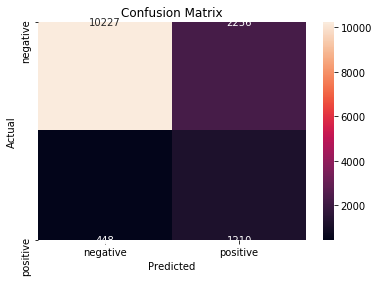

Accuracy of SVM when alpha=0.0001 is 0.16158687504419772


In [36]:

SGD_tf_idf =SGDClassifier(loss='hinge',learning_rate='constant',class_weight='balanced',alpha=c_tf_idf_lin,penalty=penalty_lin_tf_idf,eta0=0.1,max_iter=1000)
SGD_tf_idf_lin=SGD_tf_idf.fit(X_train_tf_idf,y_train)

cal_clf_tf_idf_lin=CalibratedClassifierCV(SGD_tf_idf_lin,cv='prefit')
cal_clf_tf_idf_lin.fit(X_CV_tf_idf,y_CV)

y_pred=cal_clf_tf_idf_lin.predict(X_test_tf_idf)
print(classification_report(y_test,y_pred))

#predict probabilities
y_Test_pred_proba = cal_clf_tf_idf_lin.predict_proba(X_test_tf_idf)[:,1]
y_Train_pred_proba = cal_clf_tf_idf_lin.predict_proba(X_train_tf_idf)[:,1]

#code for AUC
fpr_Test, tpr_Test, thresholds_Test = roc_curve(y_test, y_Test_pred_proba)
fpr_Train, tpr_Train, thresholds_train = roc_curve(y_train, y_Train_pred_proba)
print("Test data AUC of SVM with tf_idf Implentation  : ",roc_auc_score(y_test,y_Test_pred_proba))
AUC_tf_idf_lin=roc_auc_score(y_test,y_Test_pred_proba)
print("Train data AUC of SVM with tf_idf Implentation  : ",roc_auc_score(y_train,y_Train_pred_proba))


#generate plot
plt.plot(fpr_Test,tpr_Test, label='SVM Test ROC')
plt.plot(fpr_Train,tpr_Train, label='SVM Train ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('SVM ROC curve')
plt.show()


#confusion matrix of train data
best_t = find_best_threshold(thresholds_train, fpr_Train, tpr_Train)
print("Train confusion matrix")
conf_matrix=confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t))
print(confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t)))

class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#confusion matrix of test data
best_t = find_best_threshold(thresholds_Test, fpr_Test, tpr_Test)
print("Test confusion matrix")
conf_matrix=confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t))
print(confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t)))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy_tf_idf_lin=cal_clf_tf_idf_lin.score(X_test_tf_idf, y_test)
print('Accuracy of SVM when alpha={} is {}'.format(c_tf_idf_lin,Accuracy_tf_idf_lin))

<h4>Top 10 Negative features</h4>

In [37]:
Weight_index=SGD_BOW_lin.coef_[0].argsort()
#print(SGD_BOW_lin.coef_[0])
#print(Weight_index)
#print(SGD_BOW_lin.coef_[0][Weight_index])
print(np.take(BOW_vec.get_feature_names(),Weight_index[0:10]))

['thought' 'instead' 'life' 'money' 'dry' 'pieces' 'not' 'artificial'
 'leaves' 'version']


<h4>Top 10 Positive features</h4>

In [38]:
Weight_index=SGD_BOW_lin.coef_[0].argsort()
weight_index_len=len(SGD_BOW_lin.coef_[0])
print(np.take(BOW_vec.get_feature_names(),Weight_index[weight_index_len-10:]))

['highly' 'salad' 'cold' 'clean' 'amazing' 'delicious' 'best' 'variety'
 'yummy' 'loves']


###  Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [39]:

max1=0
AUC_Train=[]
AUC_CV=[]
#alpha = [10**x for x in range(-4,5)]
#alpha = [10**-4]
for c in tqdm(alpha):        
    model=SVC(C=c, kernel='rbf', probability=True, cache_size=200, class_weight='balanced', decision_function_shape='ovo')
    model_tf_idf=model.fit(X_train_tf_idf,y_train)         
    y_CV_pred_proba = model_tf_idf.predict_proba(X_CV_tf_idf)[:,1]          
    #y_CV_pred_proba = model_tf_idf.predict_proba(X_CV_tf_idf) [:,1] 
    y_Train_pred_proba = model_tf_idf.predict_proba(X_train_tf_idf)[:,1]     
    temp=roc_auc_score(y_CV,y_CV_pred_proba)
    AUC_CV.append(roc_auc_score(y_CV,y_CV_pred_proba))
    if max1 < temp:
        max1=temp        
        c_opt=c
    AUC_Train.append(roc_auc_score(y_train,y_Train_pred_proba))

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [18:12<00:00, 121.43s/it]


AUC is max when alpha is 10 with AUC = 0.8935049774678119


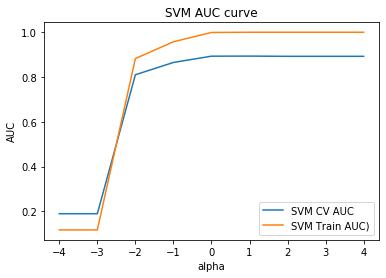

In [40]:
#Generate plot
print("AUC is max when alpha is {} with AUC = {}".format(c_opt,max1))
c_tf_idf_rbf=c_opt
plt.plot(np.log10(alpha),AUC_CV, label='SVM CV AUC')
plt.plot(np.log10(alpha),AUC_Train,label='SVM Train AUC)')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.legend()
plt.title('SVM AUC curve')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.13      0.22     12483
           1       0.13      0.99      0.23      1658

    accuracy                           0.23     14141
   macro avg       0.56      0.56      0.23     14141
weighted avg       0.89      0.23      0.22     14141

Test data AUC of SVM with tf_idf Implentation  :  0.8538601641779261
Train data AUC of SVM with tf_idf Implentation  :  1.0


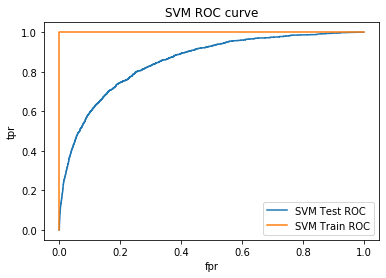

the maximum value of tpr*(1-fpr) 1.0 for threshold 0.385
Train confusion matrix
[[1068    0]
 [   0 8830]]


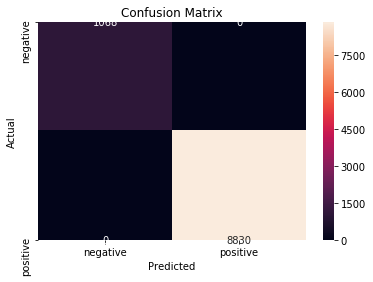

the maximum value of tpr*(1-fpr) 0.597870715753642 for threshold 0.936
Test confusion matrix
[[9353 3130]
 [ 335 1323]]


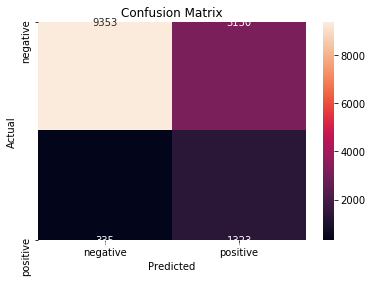

Accuracy of SVM when alpha=10 is 0.22728237041227636


In [41]:

SVC_tf_idf =SVC(C=c_tf_idf_rbf, kernel='rbf', probability=True, cache_size=200, class_weight='balanced', decision_function_shape='ovo')
SVC_tf_idf_rbf=SVC_tf_idf.fit(X_train_tf_idf,y_train)

#cal_clf_BOW_lin=CalibratedClassifierCV(SVC_BOW_rbf,cv='prefit')
#cal_clf_BOW_lin.fit(X_CV_BOW,y_CV)

y_pred=SVC_tf_idf_rbf.predict(X_test_tf_idf)
print(classification_report(y_test,y_pred))

#predict probabilities
y_Test_pred_proba = SVC_tf_idf_rbf.predict_proba(X_test_tf_idf)[:,1]
y_Train_pred_proba = SVC_tf_idf_rbf.predict_proba(X_train_tf_idf)[:,1]

#code for AUC
fpr_Test, tpr_Test, thresholds_Test = roc_curve(y_test, y_Test_pred_proba)
fpr_Train, tpr_Train, thresholds_train = roc_curve(y_train, y_Train_pred_proba)
print("Test data AUC of SVM with tf_idf Implentation  : ",roc_auc_score(y_test,y_Test_pred_proba))
AUC_tf_idf_rbf=roc_auc_score(y_test,y_Test_pred_proba)
print("Train data AUC of SVM with tf_idf Implentation  : ",roc_auc_score(y_train,y_Train_pred_proba))


#generate plot
plt.plot(fpr_Test,tpr_Test, label='SVM Test ROC')
plt.plot(fpr_Train,tpr_Train, label='SVM Train ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('SVM ROC curve')
plt.show()


#confusion matrix of train data
best_t = find_best_threshold(thresholds_train, fpr_Train, tpr_Train)
print("Train confusion matrix")
conf_matrix=confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t))
print(confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t)))

class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#confusion matrix of test data
best_t = find_best_threshold(thresholds_Test, fpr_Test, tpr_Test)
print("Test confusion matrix")
conf_matrix=confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t))
print(confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t)))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy_tf_idf_rbf=SVC_tf_idf_rbf.score(X_test_tf_idf, y_test)
print('Accuracy of SVM when alpha={} is {}'.format(c_tf_idf_rbf,Accuracy_tf_idf_rbf))

###   Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [42]:
i=0
list_of_sentance=[]
for sentance in tqdm(preprocessed_reviews):
    list_of_sentance.append(sentance.split())
print(list_of_sentance[1:2])
print('\n')
print(type(preprocessed_reviews))

100%|████████████████████████████████████████████████████████████████████████| 28281/28281 [00:00<00:00, 101058.83it/s]


[['remember', 'seeing', 'show', 'aired', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'lp', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'preschoolers', 'turned', 'whole', 'school', 'purchasing', 'cd', 'along', 'books', 'children', 'tradition', 'lives', 'whole', 'series', 'great', 'way', 'spend', 'time', 'child']]


<class 'list'>


In [43]:
print(list_of_sentance[0:1])
X_1, X_test_Avg_W2V_sent, y_t, y_test = train_test_split(list_of_sentance, y, test_size=0.3)
X_train_Avg_W2V_sent, CV_Avg_W2V_sent, y_train, y_CV = train_test_split(X_1, y_t, test_size=0.3)
print(X_train_Avg_W2V_sent[0:1])


[['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'roses', 'love', 'new', 'words', 'book', 'introduces', 'silliness', 'classic', 'book', 'willing', 'bet', 'son', 'still', 'able', 'recite', 'memory', 'college', 'every', 'book', 'educational']]
[['drink', 'ginger', 'tea', 'tried', 'product', 'even', 'though', 'labeled', 'lemon', 'ginger', 'tea', 'not', 'think', 'tea', 'ginger', 'label', 'reads', 'organic', 'lemon', 'ginger', 'tea', 'underneath', 'says', 'contains', 'organic', 'carob', 'organic', 'chicory', 'organic', 'african', 'rooibos', 'lemon', 'myrtle', 'not', 'ginger', 'tea', 'not', 'labeled', 'b', 'thomas', 'wrong', 'description', 'product']]


In [44]:
w2v_model=Word2Vec(X_train_Avg_W2V_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7965
sample words  ['drink', 'ginger', 'tea', 'tried', 'product', 'even', 'though', 'labeled', 'lemon', 'not', 'think', 'label', 'reads', 'organic', 'underneath', 'says', 'contains', 'carob', 'chicory', 'african', 'rooibos', 'myrtle', 'b', 'thomas', 'wrong', 'description', 'expecting', 'real', 'expresso', 'instant', 'coffee', 'use', 'make', 'amazon', 'products', 'better', 'represents', 'distance', 'dedicated', 'user', 'cytomax', 'since', 'smooth', 'tastes', 'great', 'delivers', 'dose', 'right', 'blend', 'carbohydrates']


In [45]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import  tqdm
X_train_Avg_W2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train_Avg_W2V_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero's with length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_Avg_W2V.append(sent_vec)
print(len(X_train_Avg_W2V))
print(len(X_train_Avg_W2V[0]))
print(X_train_Avg_W2V[0:1])

100%|███████████████████████████████████████████████████████████████████████████| 13857/13857 [00:30<00:00, 448.96it/s]


13857
50
[array([-1.05911716e-01, -1.85634272e-01, -5.40533084e-02, -1.54505153e-01,
        1.15198676e-01,  1.61923984e-01, -3.33719837e-01, -3.13700560e-01,
       -4.79558148e-02, -8.62045684e-02, -1.05962307e-01,  4.71312514e-01,
       -3.25912033e-01, -5.80136225e-01,  8.23417338e-01, -1.91725654e-01,
       -3.59648023e-01,  5.35593705e-01,  4.59074594e-01,  1.00229412e+00,
        4.05444423e-01,  7.96950065e-01, -3.25547649e-01,  2.03475891e-01,
        1.51065486e-01,  6.87424790e-01, -1.40680721e-02,  9.17838442e-01,
        3.12973262e-01, -7.06847880e-01, -9.57678277e-02,  3.94447835e-01,
        4.48446026e-01,  5.48901864e-01, -2.65902861e-01,  2.71713378e-01,
       -2.52387922e-01,  4.42795892e-02,  1.19579875e-03,  1.08861665e+00,
        6.41034450e-01, -3.77892446e-01,  1.56053534e-01, -2.91916329e-01,
       -2.06805371e-03,  2.42536744e-01,  5.49517016e-01, -1.25069862e+00,
        3.34162934e-01,  9.40805116e-02])]


In [46]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import  tqdm
CV_Avg_W2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(CV_Avg_W2V_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero's with length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    CV_Avg_W2V.append(sent_vec)
print(len(CV_Avg_W2V))
print(len(CV_Avg_W2V[0]))
print(CV_Avg_W2V[0:1])

100%|█████████████████████████████████████████████████████████████████████████████| 5939/5939 [00:16<00:00, 359.18it/s]


5939
50
[array([-2.48752606e-01, -8.85383381e-02,  1.15389427e-02, -2.44866755e-01,
       -2.31889055e-01,  2.80817862e-01, -5.93628622e-02, -2.77724160e-02,
       -3.90489157e-01, -1.56105914e-01, -1.93606169e-01,  4.97017292e-01,
       -1.05941804e-01, -7.38907568e-01,  8.47948309e-01, -2.96447726e-01,
       -3.65184419e-01,  4.86963707e-01,  3.21788827e-01,  7.32255872e-01,
        1.28432031e-01,  6.04385433e-01, -1.92582952e-01, -7.83593868e-03,
        1.85258845e-01,  7.57165528e-01,  4.49847060e-02,  7.51605526e-01,
       -2.15802787e-01, -5.46361802e-01, -6.33525284e-01,  3.44520570e-01,
        3.35042499e-01,  4.61427376e-01, -1.16492596e-01, -1.01711166e-01,
       -3.70352405e-01,  2.72203161e-01,  1.32572113e-02,  7.82822252e-01,
        3.28448547e-01, -5.28844782e-01, -6.42502817e-01, -5.00241945e-02,
        2.03596310e-01, -6.31899557e-02,  3.10132042e-01, -1.16204460e+00,
        3.41581548e-01,  8.15883505e-04])]


In [47]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import  tqdm
X_test_Avg_W2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test_Avg_W2V_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero's with length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_Avg_W2V.append(sent_vec)
print(len(X_test_Avg_W2V))
print(len(X_test_Avg_W2V[0]))
print(X_test_Avg_W2V[0:1])

100%|█████████████████████████████████████████████████████████████████████████████| 8485/8485 [00:19<00:00, 426.61it/s]


8485
50
[array([-0.29757295, -0.57130816, -0.2548667 , -0.26368715, -0.41735411,
        0.32207906, -0.16879128, -0.47783598, -0.0568423 , -0.46980247,
       -0.27699372, -0.07177889, -0.21354323, -0.49670946,  0.63855591,
       -0.22718055,  0.1671703 ,  0.27446317,  0.39667739,  0.3454915 ,
        0.42840592,  0.77294321,  0.05921927, -0.27249058,  0.11062017,
        0.42414909, -0.54218632,  0.76344046,  0.00568296, -0.37268889,
       -0.5511199 , -0.04869325,  0.33538069, -0.04010781,  0.11714873,
        0.2739433 , -0.65453454,  0.46315587, -0.34459359,  1.56737982,
       -0.26536049, -0.41134776, -0.82173124,  0.26656221,  0.07759155,
       -0.51853841,  0.20594848, -0.97621708,  0.11144035, -0.44915538])]


In [48]:
from sklearn.preprocessing import StandardScaler


SS=StandardScaler(with_mean=False).fit(X_train_Avg_W2V)
X_train_Avg_W2V=SS.transform(X_train_Avg_W2V)
X_CV_Avg_W2V= SS.transform(CV_Avg_W2V)
X_test_Avg_W2V=SS.transform(X_test_Avg_W2V)
print(X_train_Avg_W2V[0:1])
print("\n",len(X_train_Avg_W2V))


[[-0.48743018 -0.92522297 -0.24343528 -1.35951027  0.70635249  0.87750174
  -1.62664785 -1.75060353 -0.30298098 -0.41956925 -0.91249429  1.61667274
  -1.07068506 -2.11891885  3.96708538 -0.79084605 -1.74239354  2.24122357
   2.26616108  6.51095151  1.46187834  3.43430955 -1.91080788  1.14015444
   0.80461261  3.03966271 -0.05855028  3.49067875  1.4177331  -2.20063278
  -0.35391831  1.43560208  2.5585068   3.26751616 -1.55629038  0.89731003
  -1.46167983  0.24897652  0.00922887  3.5356101   2.89274956 -2.67184568
   0.54629213 -0.91123431 -0.00787967  1.00732496  3.5776847  -4.00994792
   1.29591219  0.48673896]]

 13857


In [49]:
max1=0
AUC_Train_l1=[]
AUC_Train_l2=[]
AUC_CV_l1=[]
AUC_CV_l2=[]
#alpha = [10**x for x in range(-4,5)]
#print(alpha)
#alpha = [10**-4]
penalty_lst=['l1','l2']
#penalty_lin_opt=None
for pnlty in penalty_lst:
    for c in alpha: 
        #print(pnlty)
        model_Avg_W2V=SGDClassifier(loss='hinge',learning_rate='constant',alpha=c,penalty=pnlty,eta0=0.1,max_iter=1000)
        model_Avg_W2V=model_Avg_W2V.fit(X_train_Avg_W2V,y_train)         
        #y_CV_pred_proba = model_BOW.predict_proba(CV_BOW)[:,1]      
        cal_clf_Avg_W2V_cv=CalibratedClassifierCV(model_Avg_W2V,cv='prefit')
        cal_clf_Avg_W2V_cv.fit(X_train_Avg_W2V,y_train)
        y_CV_pred_proba=cal_clf_Avg_W2V_cv.predict_proba(X_CV_Avg_W2V) [:,1] 
        y_Train_pred_proba = cal_clf_Avg_W2V_cv.predict_proba(X_train_Avg_W2V)[:,1] 
        #print(y_CV_pred_proba)
        #print(y_CV)
        if pnlty == 'l1':
            AUC_CV_l1.append(roc_auc_score(y_CV,y_CV_pred_proba))
            AUC_Train_l1.append(roc_auc_score(y_train,y_Train_pred_proba))
        else:
            AUC_CV_l2.append(roc_auc_score(y_CV,y_CV_pred_proba))
            AUC_Train_l2.append(roc_auc_score(y_train,y_Train_pred_proba))
        temp=roc_auc_score(y_CV,y_CV_pred_proba)
        
        if max1 < temp:
            max1=temp        
            c_opt=c
            penalty_lin_Avg_W2V=pnlty
    

AUC is max when alpha is 0.0001, penalty is l1 with AUC = 0.8814453064749975


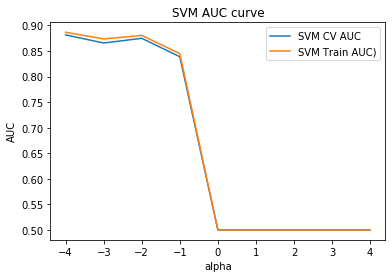

In [50]:
#Generate plot
#print(penalty_lin_BOW)
print("AUC is max when alpha is {}, penalty is {} with AUC = {}".format(c_opt,penalty_lin_Avg_W2V,max1))
c_Avg_W2V_lin=c_opt
if penalty_lin_Avg_W2V == 'l1':
    AUC_CV=AUC_CV_l1   
    AUC_Train=AUC_Train_l1
else:
    AUC_CV=AUC_CV_l2
    AUC_Train=AUC_Train_l2
plt.plot(np.log10(alpha),AUC_CV, label='SVM CV AUC')
plt.plot(np.log10(alpha),AUC_Train,label='SVM Train AUC)')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.legend()
plt.title('SVM AUC curve')
plt.show()


              precision    recall  f1-score   support

           0       0.79      0.82      0.80      4143
           1       0.82      0.79      0.80      4342

    accuracy                           0.80      8485
   macro avg       0.80      0.80      0.80      8485
weighted avg       0.80      0.80      0.80      8485

Test data AUC of SVM with Avg_W2V Implentation  :  0.8828508526310606
Train data AUC of SVM with Avg_W2V Implentation  :  0.8848017823089336


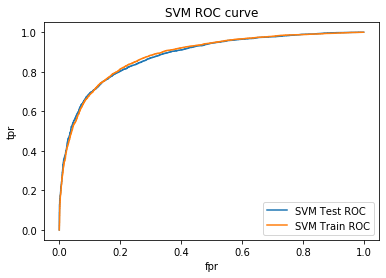

the maximum value of tpr*(1-fpr) 0.6514497929641138 for threshold 0.497
Train confusion matrix
[[5618 1199]
 [1475 5565]]


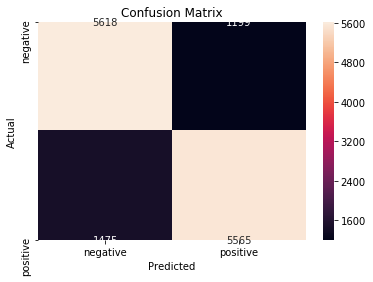

the maximum value of tpr*(1-fpr) 0.6459979834237836 for threshold 0.499
Test confusion matrix
[[3387  756]
 [ 911 3431]]


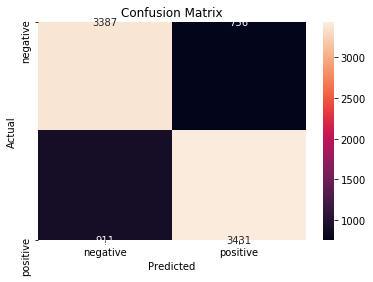

Accuracy of SVM when alpha=0.0001, with penalty = l1 is 0.8032999410724808


In [51]:
SGD_Avg_W2V =SGDClassifier(loss='hinge',learning_rate='constant',alpha=c_Avg_W2V_lin,penalty=penalty_lin_Avg_W2V,eta0=0.1,max_iter=1000)
SGD_Avg_W2V_lin=SGD_Avg_W2V.fit(X_train_Avg_W2V,y_train)

cal_clf_Avg_W2V_lin=CalibratedClassifierCV(SGD_Avg_W2V_lin,cv='prefit')
cal_clf_Avg_W2V_lin.fit(X_CV_Avg_W2V,y_CV)

y_pred=cal_clf_Avg_W2V_lin.predict(X_test_Avg_W2V)
print(classification_report(y_test,y_pred))

#predict probabilities
y_Test_pred_proba = cal_clf_Avg_W2V_lin.predict_proba(X_test_Avg_W2V)[:,1]
y_Train_pred_proba = cal_clf_Avg_W2V_lin.predict_proba(X_train_Avg_W2V)[:,1]

#code for AUC
fpr_Test, tpr_Test, thresholds_Test = roc_curve(y_test, y_Test_pred_proba)
fpr_Train, tpr_Train, thresholds_train = roc_curve(y_train, y_Train_pred_proba)
print("Test data AUC of SVM with Avg_W2V Implentation  : ",roc_auc_score(y_test,y_Test_pred_proba))
AUC_Avg_W2V_lin=roc_auc_score(y_test,y_Test_pred_proba)
print("Train data AUC of SVM with Avg_W2V Implentation  : ",roc_auc_score(y_train,y_Train_pred_proba))


#generate plot
plt.plot(fpr_Test,tpr_Test, label='SVM Test ROC')
plt.plot(fpr_Train,tpr_Train, label='SVM Train ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('SVM ROC curve')
plt.show()


#confusion matrix of train data
best_t = find_best_threshold(thresholds_train, fpr_Train, tpr_Train)
print("Train confusion matrix")
conf_matrix=confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t))
print(confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t)))

class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#confusion matrix of test data
best_t = find_best_threshold(thresholds_Test, fpr_Test, tpr_Test)
print("Test confusion matrix")
conf_matrix=confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t))
print(confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t)))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy_Avg_W2V_lin=cal_clf_Avg_W2V_lin.score(X_test_Avg_W2V, y_test)
print('Accuracy of SVM when alpha={}, with penalty = {} is {}'.format(c_Avg_W2V_lin,penalty_lin_Avg_W2V,Accuracy_Avg_W2V_lin))



###   Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [52]:
max1=0
AUC_Train=[]
AUC_CV=[]
#alpha = [10**x for x in range(-4,5)]
#alpha = [10**-4]
for c in tqdm(alpha):        
    model=SVC(C=c, kernel='rbf', probability=True, cache_size=200, class_weight='balanced', decision_function_shape='ovo')
    model_Avg_W2V=model.fit(X_train_Avg_W2V,y_train)         
    y_CV_pred_proba = model_Avg_W2V.predict_proba(X_CV_Avg_W2V)[:,1]      
    y_CV_pred_proba=model_Avg_W2V.predict_proba(X_CV_Avg_W2V) [:,1] 
    y_Train_pred_proba = model_Avg_W2V.predict_proba(X_train_Avg_W2V)[:,1] 
    #print(y_CV_pred_proba)
    #print(y_CV)
    temp=roc_auc_score(y_CV,y_CV_pred_proba)
    AUC_CV.append(roc_auc_score(y_CV,y_CV_pred_proba))
    if max1 < temp:
        max1=temp        
        c_opt=c
    AUC_Train.append(roc_auc_score(y_train,y_Train_pred_proba))


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [32:56<00:00, 219.58s/it]


AUC is max when alpha is 1 with AUC = 0.907240085086075


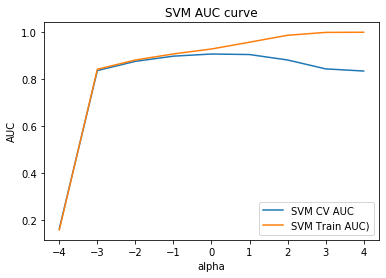

In [53]:
#Generate plot
print("AUC is max when alpha is {} with AUC = {}".format(c_opt,max1))
c_Avg_W2V_rbf=c_opt
plt.plot(np.log10(alpha),AUC_CV, label='SVM CV AUC')
plt.plot(np.log10(alpha),AUC_Train,label='SVM Train AUC)')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.legend()
plt.title('SVM AUC curve')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      4143
           1       0.85      0.82      0.84      4342

    accuracy                           0.84      8485
   macro avg       0.84      0.84      0.84      8485
weighted avg       0.84      0.84      0.84      8485

Test data AUC of SVM with Avg_W2V Implentation  :  0.913427336826375
Train data AUC of SVM with Avg_W2V Implentation  :  0.928669125565098


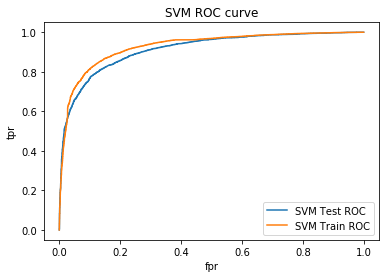

the maximum value of tpr*(1-fpr) 0.7390165962100098 for threshold 0.487
Train confusion matrix
[[5919  898]
 [1048 5992]]


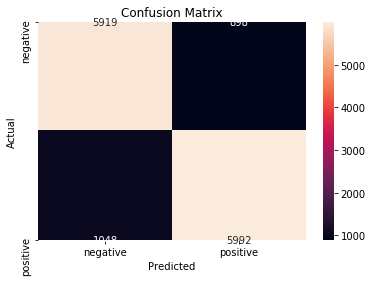

the maximum value of tpr*(1-fpr) 0.7012574861417364 for threshold 0.551
Test confusion matrix
[[3595  548]
 [ 833 3509]]


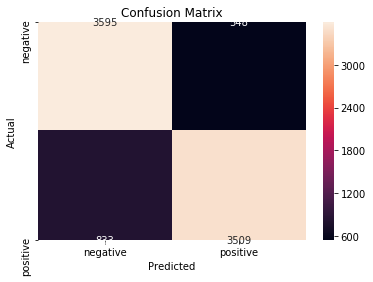

Accuracy of SVM when alpha=1 is 0.8360636417206836


In [54]:
SVC_Avg_W2V =SVC(C=c_Avg_W2V_rbf, kernel='rbf', probability=True, cache_size=200, class_weight='balanced', decision_function_shape='ovo')
SVC_Avg_W2V_rbf=SVC_Avg_W2V.fit(X_train_Avg_W2V,y_train)

#cal_clf_BOW_lin=CalibratedClassifierCV(SVC_BOW_rbf,cv='prefit')
#cal_clf_BOW_lin.fit(X_CV_BOW,y_CV)

y_pred=SVC_Avg_W2V_rbf.predict(X_test_Avg_W2V)
print(classification_report(y_test,y_pred))

#predict probabilities
y_Test_pred_proba = SVC_Avg_W2V_rbf.predict_proba(X_test_Avg_W2V)[:,1]
y_Train_pred_proba = SVC_Avg_W2V_rbf.predict_proba(X_train_Avg_W2V)[:,1]

#code for AUC
fpr_Test, tpr_Test, thresholds_Test = roc_curve(y_test, y_Test_pred_proba)
fpr_Train, tpr_Train, thresholds_train = roc_curve(y_train, y_Train_pred_proba)
print("Test data AUC of SVM with Avg_W2V Implentation  : ",roc_auc_score(y_test,y_Test_pred_proba))
AUC_Avg_W2V_rbf=roc_auc_score(y_test,y_Test_pred_proba)
print("Train data AUC of SVM with Avg_W2V Implentation  : ",roc_auc_score(y_train,y_Train_pred_proba))


#generate plot
plt.plot(fpr_Test,tpr_Test, label='SVM Test ROC')
plt.plot(fpr_Train,tpr_Train, label='SVM Train ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('SVM ROC curve')
plt.show()


#confusion matrix of train data
best_t = find_best_threshold(thresholds_train, fpr_Train, tpr_Train)
print("Train confusion matrix")
conf_matrix=confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t))
print(confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t)))

class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#confusion matrix of test data
best_t = find_best_threshold(thresholds_Test, fpr_Test, tpr_Test)
print("Test confusion matrix")
conf_matrix=confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t))
print(confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t)))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy_Avg_W2V_rbf=SVC_Avg_W2V_rbf.score(X_test_Avg_W2V, y_test)
print('Accuracy of SVM when alpha={} is {}'.format(c_Avg_W2V_rbf,Accuracy_Avg_W2V_rbf))	

###   Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [55]:
X_1, X_test, y_t, y_test = train_test_split(preprocessed_reviews, y, test_size=0.3)
X_train, CV, y_train, y_CV = train_test_split(X_1, y_t, test_size=0.3)# Please write all the code with proper documentation

In [56]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
print(list_of_sentance_train[1:2])



[['buying', 'nature', 'path', 'gluten', 'free', 'foods', 'number', 'years', 'fully', 'satisfied', 'access', 'somewhat', 'lower', 'prices', 'traditional', 'grocery', 'stores', 'put', 'products', 'delighted', 'amazon', 'price', 'virtually', 'identical', 'prices', 'offered', 'discount', 'organic', 'foods', 'market', 'purchased', 'past', 'doubt', 'find', 'nature', 'path', 'products', 'lower', 'anywhere', 'else', 'particularly', 'consider', 'no', 'sales', 'tax', 'free', 'shipping', 'order', 'large', 'enough', 'also', 'contacted', 'nature', 'path', 'question', 'one', 'products', 'mesa', 'sunrise', 'flakes', 'customer', 'service', 'excellent', 'friendly', 'much', 'nicer', 'typically', 'get', 'states', 'canadian', 'company', 'b', 'c', 'sounds', 'like', 'commercial', 'not', 'intended', 'entirely', 'satisfied', 'nature', 'path', 'foods', 'years', 'no', 'complaints', 'company', 'good', 'job', 'deserve', 'referrals', 'everybody', 'wins', 'long', 'time', 'user', 'eater', 'love', 'em']]


In [57]:
i=0
list_of_sentance_cv=[]
for sentance in CV:
    list_of_sentance_cv.append(sentance.split())
print(list_of_sentance_cv[1:2])


[['breakfast', 'blend', 'perfect', 'start', 'day', 'warm', 'mellow', 'taste', 'wonderful', 'delicious']]


In [58]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
print(list_of_sentance_test[1:2])

[['herbs', 'young', 'taste', 'yet', 'coming', 'along', 'previously', 'grew', 'salad', 'greens', 'thrived', 'not', 'handy', 'fresh', 'herbs', 'growing', 'especially', 'one', 'considers', 'high', 'prices', 'fresh', 'herbs', 'grocery', 'store', 'trying', 'patient', 'check', 'growth', 'daily', 'basis', 'great', 'fun']]


In [59]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_train)
tf_idf_matrix = model.transform(X_train)

# we are converting a dictionary with word as a key, and the idf as a value


dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [60]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tf_idf_W2V = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tf_idf_W2V.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 13857/13857 [06:20<00:00, 36.44it/s]


In [61]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

CV_tf_idf_W2V = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    CV_tf_idf_W2V.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5939/5939 [02:19<00:00, 42.43it/s]


In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_test_tf_idf_W2V = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tf_idf_W2V.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 8485/8485 [03:41<00:00, 38.37it/s]


In [63]:
from sklearn.preprocessing import StandardScaler

SS=StandardScaler(with_mean=False).fit(X_train_tf_idf_W2V)
X_train_tf_idf_W2V = SS.transform(X_train_tf_idf_W2V)
X_CV_tf_idf_W2V= SS.transform(CV_tf_idf_W2V)
X_test_tf_idf_W2V=SS.transform(X_test_tf_idf_W2V)

In [64]:

max1=0
AUC_Train_l1=[]
AUC_Train_l2=[]
AUC_CV_l1=[]
AUC_CV_l2=[]
#alpha = [10**x for x in range(-4,5)]
#print(alpha)
#alpha = [10**-4]
penalty_lst=['l1','l2']
#penalty_lin_opt=None
for pnlty in penalty_lst:
    for c in alpha: 
        #print(pnlty)
        model=SGDClassifier(loss='hinge',learning_rate='constant',alpha=c,penalty=pnlty,eta0=0.1,max_iter=1000)
        model_tf_idf_W2V=model.fit(X_train_tf_idf_W2V,y_train)         
        #y_CV_pred_proba = model_BOW.predict_proba(CV_BOW)[:,1]      
        cal_clf_tf_idf_W2V_cv=CalibratedClassifierCV(model_tf_idf_W2V,cv='prefit')
        cal_clf_tf_idf_W2V_cv.fit(X_train_tf_idf_W2V,y_train)
        y_CV_pred_proba=cal_clf_tf_idf_W2V_cv.predict_proba(X_CV_tf_idf_W2V) [:,1] 
        y_Train_pred_proba = cal_clf_tf_idf_W2V_cv.predict_proba(X_train_tf_idf_W2V)[:,1] 
        #print(y_CV_pred_proba)
        #print(y_CV)
        if pnlty == 'l1':
            AUC_CV_l1.append(roc_auc_score(y_CV,y_CV_pred_proba))
            AUC_Train_l1.append(roc_auc_score(y_train,y_Train_pred_proba))
        else:
            AUC_CV_l2.append(roc_auc_score(y_CV,y_CV_pred_proba))
            AUC_Train_l2.append(roc_auc_score(y_train,y_Train_pred_proba))
        temp=roc_auc_score(y_CV,y_CV_pred_proba)
        
        if max1 < temp:
            max1=temp        
            c_opt=c
            penalty_lin_tf_idf_W2V=pnlty


AUC is max when alpha is 0.0001, penalty is l1 with AUC = 0.8744146007852958


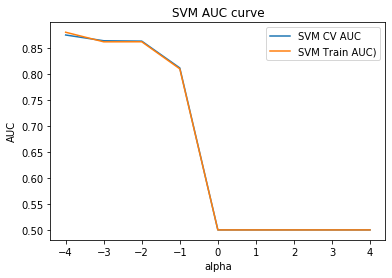

In [65]:
print("AUC is max when alpha is {}, penalty is {} with AUC = {}".format(c_opt,penalty_lin_tf_idf_W2V,max1))
c_tf_idf_W2V_lin=c_opt
if penalty_lin_tf_idf_W2V == 'l1':
    AUC_CV=AUC_CV_l1   
    AUC_Train=AUC_Train_l1
else:
    AUC_CV=AUC_CV_l2
    AUC_Train=AUC_Train_l2
plt.plot(np.log10(alpha),AUC_CV, label='SVM CV AUC')
plt.plot(np.log10(alpha),AUC_Train,label='SVM Train AUC)')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.legend()
plt.title('SVM AUC curve')
plt.show()


              precision    recall  f1-score   support

           0       0.77      0.79      0.78      4213
           1       0.79      0.77      0.78      4272

    accuracy                           0.78      8485
   macro avg       0.78      0.78      0.78      8485
weighted avg       0.78      0.78      0.78      8485

Test data AUC of SVM with tf_idf_W2V Implentation  :  0.8522496690731648
Train data AUC of SVM with tf_idf_W2V Implentation  :  0.8650548721785841


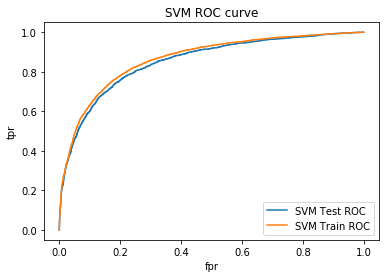

the maximum value of tpr*(1-fpr) 0.625296270837422 for threshold 0.496
Train confusion matrix
[[5391 1408]
 [1492 5566]]


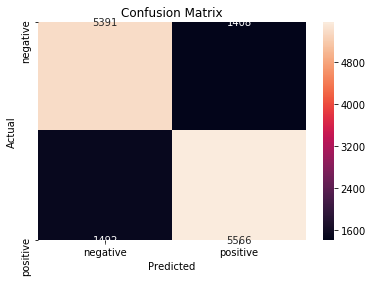

the maximum value of tpr*(1-fpr) 0.6087384686777417 for threshold 0.501
Test confusion matrix
[[3318  895]
 [ 970 3302]]


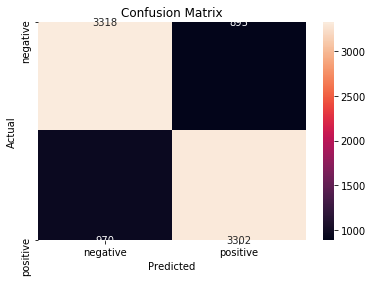

Accuracy of SVM when alpha=0.0001, with penalty = l1 is 0.7796110783736004


In [66]:
SGD_tf_idf_W2V =SGDClassifier(loss='hinge',learning_rate='constant',alpha=c_tf_idf_W2V_lin,penalty=penalty_lin_tf_idf_W2V,eta0=0.1,max_iter=1000)
SGD_tf_idf_W2V_lin=SGD_tf_idf_W2V.fit(X_train_tf_idf_W2V,y_train)

cal_clf_tf_idf_W2V_lin=CalibratedClassifierCV(SGD_tf_idf_W2V_lin,cv='prefit')
cal_clf_tf_idf_W2V_lin.fit(X_CV_tf_idf_W2V,y_CV)

y_pred=cal_clf_tf_idf_W2V_lin.predict(X_test_tf_idf_W2V)
print(classification_report(y_test,y_pred))

#predict probabilities
y_Test_pred_proba = cal_clf_tf_idf_W2V_lin.predict_proba(X_test_tf_idf_W2V)[:,1]
y_Train_pred_proba = cal_clf_tf_idf_W2V_lin.predict_proba(X_train_tf_idf_W2V)[:,1]

#code for AUC
fpr_Test, tpr_Test, thresholds_Test = roc_curve(y_test, y_Test_pred_proba)
fpr_Train, tpr_Train, thresholds_train = roc_curve(y_train, y_Train_pred_proba)
print("Test data AUC of SVM with tf_idf_W2V Implentation  : ",roc_auc_score(y_test,y_Test_pred_proba))
AUC_tf_idf_W2V_lin=roc_auc_score(y_test,y_Test_pred_proba)
print("Train data AUC of SVM with tf_idf_W2V Implentation  : ",roc_auc_score(y_train,y_Train_pred_proba))


#generate plot
plt.plot(fpr_Test,tpr_Test, label='SVM Test ROC')
plt.plot(fpr_Train,tpr_Train, label='SVM Train ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('SVM ROC curve')
plt.show()


#confusion matrix of train data
best_t = find_best_threshold(thresholds_train, fpr_Train, tpr_Train)
print("Train confusion matrix")
conf_matrix=confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t))
print(confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t)))

class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#confusion matrix of test data
best_t = find_best_threshold(thresholds_Test, fpr_Test, tpr_Test)
print("Test confusion matrix")
conf_matrix=confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t))
print(confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t)))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy_tf_idf_W2V_lin=cal_clf_tf_idf_W2V_lin.score(X_test_tf_idf_W2V, y_test)
print('Accuracy of SVM when alpha={}, with penalty = {} is {}'.format(c_tf_idf_W2V_lin,penalty_lin_tf_idf_W2V,Accuracy_tf_idf_W2V_lin))


###   Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [67]:

max1=0
AUC_Train=[]
AUC_CV=[]
#alpha = [10**x for x in range(-4,5)]
#alpha = [10**-4]
for c in tqdm(alpha):        
    model=SVC(C=c, kernel='rbf', probability=True, cache_size=200, class_weight='balanced', decision_function_shape='ovo')
    model_tf_idf_W2V=model.fit(X_train_tf_idf_W2V,y_train)         
    y_CV_pred_proba = model_tf_idf_W2V.predict_proba(X_CV_tf_idf_W2V)[:,1]      
    #cal_clf_BOW_cv=CalibratedClassifierCV(model_BOW,cv='prefit')
    #cal_clf_BOW_cv.fit(X_train_BOW,y_train)
    y_CV_pred_proba=model_tf_idf_W2V.predict_proba(X_CV_tf_idf_W2V) [:,1] 
    y_Train_pred_proba = model_tf_idf_W2V.predict_proba(X_train_tf_idf_W2V)[:,1] 
    #print(y_CV_pred_proba)
    #print(y_CV)
    temp=roc_auc_score(y_CV,y_CV_pred_proba)
    AUC_CV.append(roc_auc_score(y_CV,y_CV_pred_proba))
    if max1 < temp:
        max1=temp        
        c_opt=c
    AUC_Train.append(roc_auc_score(y_train,y_Train_pred_proba))


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [47:41<00:00, 317.95s/it]


AUC is max when alpha is 10 with AUC = 0.8977199882954181


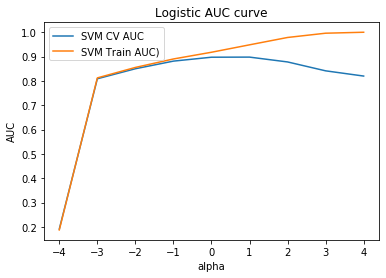

In [68]:

#Generate plot
print("AUC is max when alpha is {} with AUC = {}".format(c_opt,max1))
c_tf_idf_W2V_rbf=c_opt
plt.plot(np.log10(alpha),AUC_CV, label='SVM CV AUC')
plt.plot(np.log10(alpha),AUC_Train,label='SVM Train AUC)')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.legend()
plt.title('Logistic AUC curve')
plt.show()


              precision    recall  f1-score   support

           0       0.81      0.84      0.82      4213
           1       0.83      0.80      0.82      4272

    accuracy                           0.82      8485
   macro avg       0.82      0.82      0.82      8485
weighted avg       0.82      0.82      0.82      8485

Test data AUC of SVM with Tf_idf_W2V Implentation  :  0.8960510249619734
Train data AUC of SVM with Tf_idf_W2V Implentation  :  0.9481634552711837


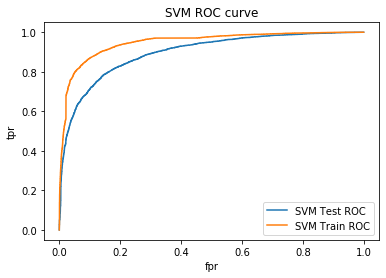

the maximum value of tpr*(1-fpr) 0.782526358721848 for threshold 0.507
Train confusion matrix
[[6096  703]
 [ 898 6160]]


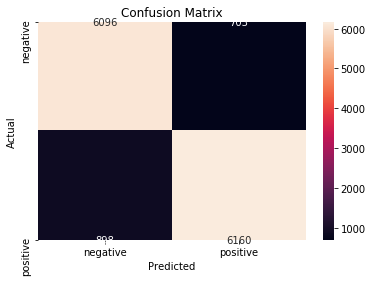

the maximum value of tpr*(1-fpr) 0.6707831386887919 for threshold 0.535
Test confusion matrix
[[3592  621]
 [ 911 3361]]


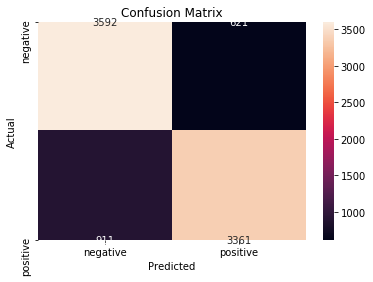

Accuracy of SVM when alpha=10 is 0.8186210960518562


In [69]:
SVC_tf_idf_W2V =SVC(C=c_tf_idf_W2V_rbf, kernel='rbf', probability=True, cache_size=200, class_weight='balanced', decision_function_shape='ovo')
SVC_tf_idf_W2V_rbf=SVC_tf_idf_W2V.fit(X_train_tf_idf_W2V,y_train)

#cal_clf_BOW_lin=CalibratedClassifierCV(SVC_BOW_rbf,cv='prefit')
#cal_clf_BOW_lin.fit(X_CV_BOW,y_CV)

y_pred=SVC_tf_idf_W2V_rbf.predict(X_test_tf_idf_W2V)
print(classification_report(y_test,y_pred))

#predict probabilities
y_Test_pred_proba = SVC_tf_idf_W2V_rbf.predict_proba(X_test_tf_idf_W2V)[:,1]
y_Train_pred_proba = SVC_tf_idf_W2V_rbf.predict_proba(X_train_tf_idf_W2V)[:,1]

#code for AUC
fpr_Test, tpr_Test, thresholds_Test = roc_curve(y_test, y_Test_pred_proba)
fpr_Train, tpr_Train, thresholds_train = roc_curve(y_train, y_Train_pred_proba)
print("Test data AUC of SVM with Tf_idf_W2V Implentation  : ",roc_auc_score(y_test,y_Test_pred_proba))
AUC_tf_idf_W2V_rbf=roc_auc_score(y_test,y_Test_pred_proba)
print("Train data AUC of SVM with Tf_idf_W2V Implentation  : ",roc_auc_score(y_train,y_Train_pred_proba))


#generate plot
plt.plot(fpr_Test,tpr_Test, label='SVM Test ROC')
plt.plot(fpr_Train,tpr_Train, label='SVM Train ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('SVM ROC curve')
plt.show()


#confusion matrix of train data
best_t = find_best_threshold(thresholds_train, fpr_Train, tpr_Train)
print("Train confusion matrix")
conf_matrix=confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t))
print(confusion_matrix(y_train, predict_with_best_t(y_Train_pred_proba, best_t)))

class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#confusion matrix of test data
best_t = find_best_threshold(thresholds_Test, fpr_Test, tpr_Test)
print("Test confusion matrix")
conf_matrix=confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t))
print(confusion_matrix(y_test, predict_with_best_t(y_Test_pred_proba, best_t)))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy_tf_idf_W2V_rbf=SVC_tf_idf_W2V_rbf.score(X_test_tf_idf_W2V, y_test)
print('Accuracy of SVM when alpha={} is {}'.format(c_tf_idf_W2V_rbf,Accuracy_tf_idf_W2V_rbf))

In [70]:
#http://zetcode.com/python/prettytable/
x=PrettyTable()
x.field_names = ["Vectorizer", "Kernal Type","Optimal regularizer", "Hyper Parameter (alpha)", "AUC","Accuracy"]
x.add_row(["BOW","Linear" ,penalty_lin_BOW, c_BOW_lin, AUC_BOW_lin,Accuracy_BOW_lin])
x.add_row(["TF-IDF", "Linear", penalty_lin_tf_idf,c_tf_idf_lin,AUC_tf_idf_lin,Accuracy_tf_idf_lin])
x.add_row(["Avg Weighted W2V","Linear" ,penalty_lin_Avg_W2V ,c_Avg_W2V_lin,AUC_Avg_W2V_lin,Accuracy_Avg_W2V_lin ])
x.add_row(["TF-IDF W2V", "Linear",penalty_lin_tf_idf_W2V ,c_tf_idf_W2V_lin,AUC_tf_idf_W2V_lin,Accuracy_tf_idf_W2V_lin ])
print(x)

+------------------+-------------+---------------------+-------------------------+--------------------+---------------------+
|    Vectorizer    | Kernal Type | Optimal regularizer | Hyper Parameter (alpha) |        AUC         |       Accuracy      |
+------------------+-------------+---------------------+-------------------------+--------------------+---------------------+
|       BOW        |    Linear   |          l2         |          0.0001         | 0.8525050280685713 | 0.25323527331871865 |
|      TF-IDF      |    Linear   |          l2         |          0.0001         | 0.8491470233051329 | 0.16158687504419772 |
| Avg Weighted W2V |    Linear   |          l1         |          0.0001         | 0.8828508526310606 |  0.8032999410724808 |
|    TF-IDF W2V    |    Linear   |          l1         |          0.0001         | 0.8522496690731648 |  0.7796110783736004 |
+------------------+-------------+---------------------+-------------------------+--------------------+---------------

In [71]:
#http://zetcode.com/python/prettytable/
x=PrettyTable()
x.field_names = ["Vectorizer", "Kernal Type","Optimal regularizer", "Hyper Parameter (alpha)", "AUC","Accuracy"]
x.add_row(["BOW","RBF" ,"-", c_BOW_rbf, AUC_BOW_rbf,Accuracy_BOW_rbf])
x.add_row(["TF-IDF", "RBF", "-",c_tf_idf_rbf,AUC_tf_idf_rbf,Accuracy_tf_idf_rbf])
x.add_row(["Avg Weighted W2V","RBF" ,"-" ,c_Avg_W2V_rbf,AUC_Avg_W2V_rbf,Accuracy_Avg_W2V_rbf ])
x.add_row(["TF-IDF W2V", "RBF","-" ,c_tf_idf_W2V_rbf,AUC_tf_idf_W2V_rbf,Accuracy_tf_idf_W2V_rbf ])
print(x)

+------------------+-------------+---------------------+-------------------------+--------------------+---------------------+
|    Vectorizer    | Kernal Type | Optimal regularizer | Hyper Parameter (alpha) |        AUC         |       Accuracy      |
+------------------+-------------+---------------------+-------------------------+--------------------+---------------------+
|       BOW        |     RBF     |          -          |            1            | 0.8785359910950544 |  0.8198147231454636 |
|      TF-IDF      |     RBF     |          -          |            10           | 0.8538601641779261 | 0.22728237041227636 |
| Avg Weighted W2V |     RBF     |          -          |            1            | 0.913427336826375  |  0.8360636417206836 |
|    TF-IDF W2V    |     RBF     |          -          |            10           | 0.8960510249619734 |  0.8186210960518562 |
+------------------+-------------+---------------------+-------------------------+--------------------+---------------

# [6] Conclusions

<li>By abouve tables we can observe that in Linear Model Abg_weighted_W2V and tf_idf_w2v performs well than BOW and tf_idf vectr implementations</li>
<li>In RBF kernel models BOW,tf_idf_W2V and Avg_weighted_W2V models performs well for test data.</li>
<li>Optimal regularizer is 'L1' and optimal alpha value is 0.0001 for linear models and 1,10 for ebf kernel models.</li>
<li>Highest accuracy is obtained for RBF kernel model with Avg_Weighted_W2V vectorizer implementation</li>